# XGBoost
This notebook depicts the use of the `XGBoost` model to predict and classify the primary cause of wildfires, drawing on various attributes like location, timing, and environmental conditions. `XGBoost`, short for eXtreme Gradient Boosting, is an advanced implementation of gradient boosted decision trees designed for speed and performance. It stands out for its ability to handle sparse data and its efficiency in computational speed, often outperforming Random Forest models in terms of prediction accuracy and efficiency, particularly on large datasets.

# Abstract

| Original Dataset | SMOTE          | Random Under-Sampling | KFold Cross Validation |
|-----------------------|----------------------|---------------|------------------------------|
| Accuracy : 0.6552     | Accuracy : 0.5930    | Accuracy: 0.4337            | Accuracy : 0.6567            |

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Load Data

In [4]:
df = pd.read_csv('cleaned_data.csv')
labels = np.array(df.pop('STAT_CAUSE_DESCR'))

df.head()

,SOURCE_SYSTEM,FIRE_YEAR,DISCOVERY_DOY,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,...,FIPS_NAME,DISCOVERY_MONTH,DISCOVERY_WEEKDAY,CONT_MONTH,CONT_WEEKDAY,DISCOVERY_HOUR,DISCOVERY_MINUTE,CONT_HOUR,CONT_MINUTE,DURATION
0,1,2004,133,133.0,0.25,38.933056,-120.404444,5.0,14,4,...,1041,5,6,5,6,8,45,15,30,405.0
1,1,2004,152,152.0,0.10,38.984167,-120.735556,13.0,11,4,...,428,5,1,5,1,19,21,20,24,63.0
2,1,2004,180,185.0,0.10,38.559167,-119.913333,5.0,14,4,...,24,6,1,7,2,16,0,14,0,7080.0
3,1,2004,180,185.0,0.10,38.559167,-119.933056,5.0,14,4,...,24,6,1,7,2,16,0,12,0,6960.0
4,1,2004,182,183.0,0.10,38.635278,-120.103611,5.0,14,4,...,25,6,6,7,4,18,0,16,0,1320.0


## Class Distribution Overview

/Library/Python/3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


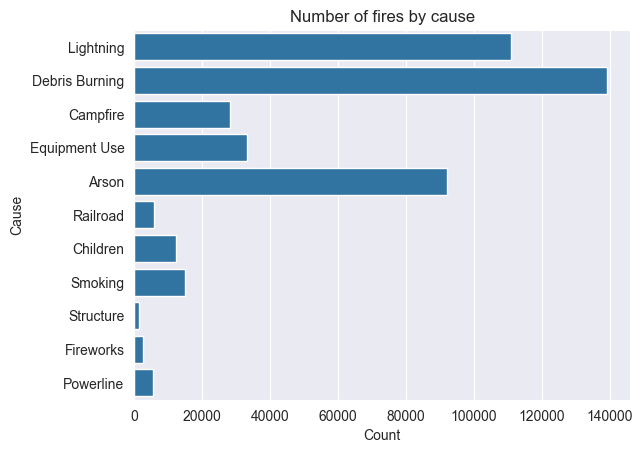

In [5]:
with open('encoders/STAT_CAUSE_DESCR_Encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)

sns.countplot(encoder.inverse_transform(labels))
plt.title('Number of fires by cause')
plt.xlabel('Count')
plt.ylabel('Cause')
plt.show()

## Data Splitting

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f'Training data: {X_train.shape[0]} samples')
print(f'Validation data: {X_val.shape[0]} samples')
print(f'Test data: {X_test.shape[0]} samples')

Training data: 285411 samples
Validation data: 71353 samples
Test data: 89191 samples


## Hyperparameter Tuning with GridSearchCV
This hyperparameter search takes many hours to run, therefore instead of using the `best_model` returned, use the model with the following hyperparameters passed in. The best hyperparameters found using this gridsearch were `colsample_bytree=0.6`, `learning_rate=0.1`, `max_depth=6`, `min_child_weight=1`, `n_estimators=300` with a validation accuracy of 65.52%.

In [7]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10],
}

model = xgb.XGBClassifier(random_state=42)

grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
val_accuracy = best_model.score(X_val, y_val)

print(f'Best parameters: {best_params}')
print(f'Best score: {best_model}')
print(f'Validation accuracy: {val_accuracy}')

KeyboardInterrupt: 

## Training the Model

In [8]:
model = xgb.XGBClassifier(colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=300, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print(f'Accuracy: {accuracy_score(y_val, y_pred)}')

Accuracy: 0.6552352388827379


## Balancing/Oversampling with SMOTE

Original training data: 285411 samples
SMOTEd training data: 976888 samples


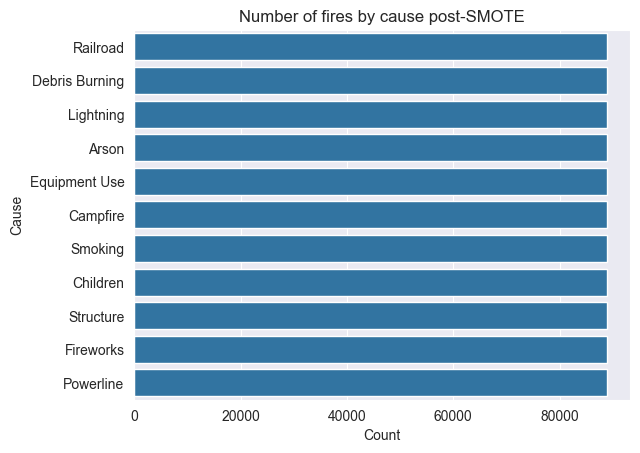

In [10]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f'Original training data: {X_train.shape[0]} samples')
print(f'SMOTEd training data: {X_train_smote.shape[0]} samples')

sns.countplot(encoder.inverse_transform(y_train_smote))
plt.title('Number of fires by cause post-SMOTE')
plt.xlabel('Count')
plt.ylabel('Cause')
plt.show()

# Train the Model with SMOTE Oversampling
The accuracy obtained with SMOTE Oversampling is `59.3%`, not as good as the original model. Therefore, we will check with under-sampling if we get better accuracy.

In [11]:
model = xgb.XGBClassifier(colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=300, random_state=42)
model.fit(X_train_smote, y_train_smote)

y_pred = model.predict(X_val)
print(f'Accuracy with SMOTE: {accuracy_score(y_val, y_pred)}')

# save the model
with open('xgboost_smote', 'wb') as f:
    pickle.dump(model, f)

Accuracy with SMOTE: 0.5930374336047538


## Under-sampling with Random Under-sampling

Original training data: 285411 samples
RUSed training data: 9790 samples


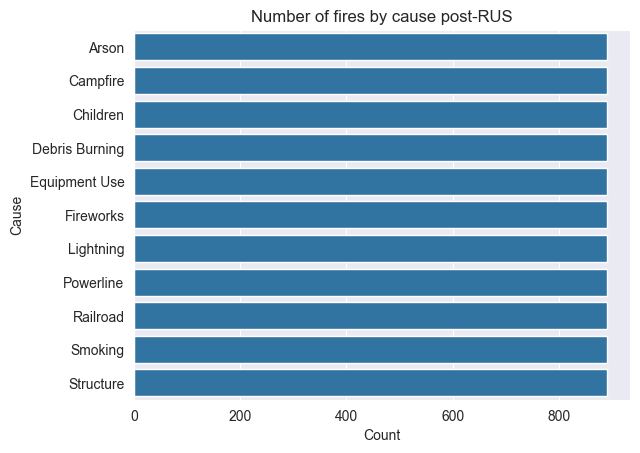

In [13]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print(f'Original training data: {X_train.shape[0]} samples')
print(f'RUSed training data: {X_train_rus.shape[0]} samples')

sns.countplot(encoder.inverse_transform(y_train_rus))
plt.title('Number of fires by cause post-RUS')
plt.xlabel('Count')
plt.ylabel('Cause')
plt.show()

## Train the Model with RUS
The accuracy obtained with Random Under-Sampling is `43.37%`, not as good as neither the original nor the SMOTE model. Therefore, we will check with k-fold if we can get better accuracy.

In [14]:
model_rus = xgb.XGBClassifier(colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=300, random_state=42)
model_rus.fit(X_train_rus, y_train_rus)

y_pred = model_rus.predict(X_val)
print(f'Accuracy with RUS: {accuracy_score(y_val, y_pred)}')


Accuracy with RUS: 0.4336888427956778


## K-Fold Cross Validation with XGBoost
The accuracy obtained with K-Fold Cross Validation is `65.52%`, which is the best accuracy obtained so far.

In [15]:
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# model with best hyperparameters
model = xgb.XGBClassifier(colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=300, random_state=42)

# k-fold cross validation
results = []

for train, test in kfold.split(df, labels):
    model.fit(df.iloc[train], labels[train])
    y_pred = model.predict(df.iloc[test])
    results.append(accuracy_score(labels[test], y_pred))
    
print(f'Accuracy with K-Fold XGBoost: {np.mean(results)}')

Accuracy with K-Fold XGBoost: 0.6567187272258412


## Results Plot
This plot depicts the accuracy obtained for each fold in the K-Fold Cross Validation.

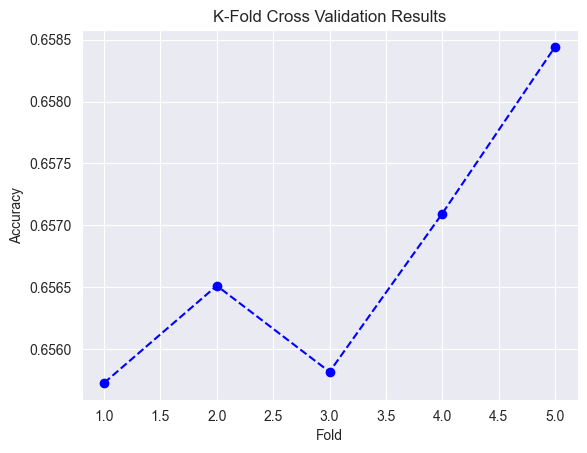

In [16]:
plt.plot(range(1, n_splits+1), results, marker='o', linestyle='--', color='b')
plt.title('K-Fold Cross Validation Results')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.show()

This plot depicts the confusion matrix for the K-Fold Cross Validation.

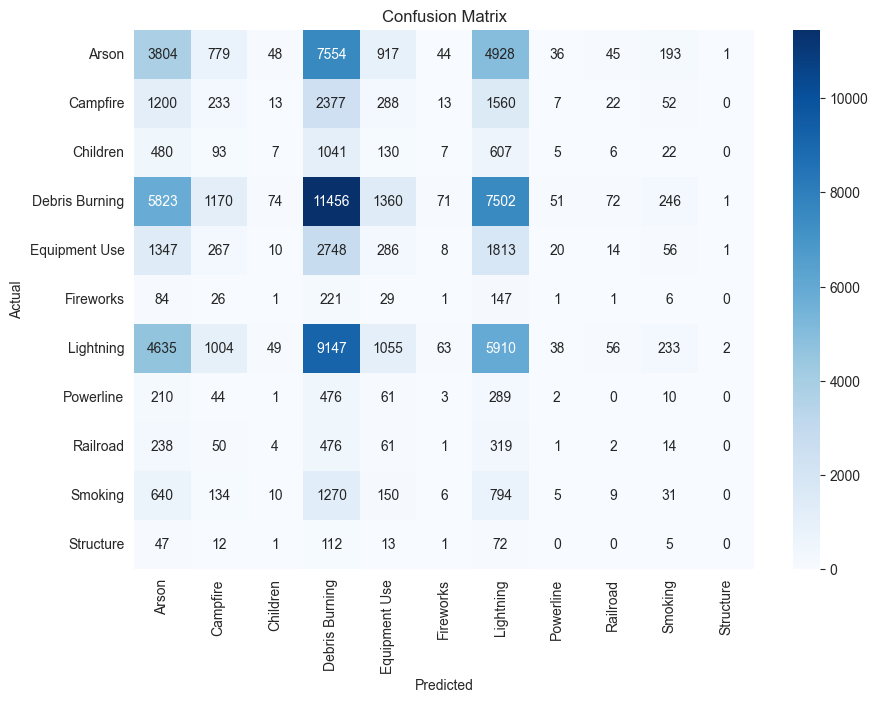

                precision    recall  f1-score   support

         Arson       0.21      0.21      0.21     18349
      Campfire       0.06      0.04      0.05      5765
      Children       0.03      0.00      0.01      2398
Debris Burning       0.31      0.41      0.35     27826
 Equipment Use       0.07      0.04      0.05      6570
     Fireworks       0.00      0.00      0.00       517
     Lightning       0.25      0.27      0.26     22192
     Powerline       0.01      0.00      0.00      1096
      Railroad       0.01      0.00      0.00      1166
       Smoking       0.04      0.01      0.02      3049
     Structure       0.00      0.00      0.00       263

      accuracy                           0.24     89191
     macro avg       0.09      0.09      0.09     89191
  weighted avg       0.21      0.24      0.22     89191


In [17]:
confusion_mat=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.inverse_transform(np.unique(labels)), yticklabels=encoder.inverse_transform(np.unique(labels)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred, target_names=encoder.inverse_transform(np.unique(labels))))

## Saving the Model

In [18]:
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)

## Making Predictions

In [23]:
with open('xgboost_model.pkl', 'rb') as f:
    model = pickle.load(f)
    
with open('encoders/STAT_CAUSE_DESCR_Encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)
    
# make predictions
y_pred = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred, target_names=encoder.inverse_transform(np.unique(labels))))

/Library/Python/3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Accuracy: 0.676043546994652
                precision    recall  f1-score   support

         Arson       0.63      0.62      0.63     18349
      Campfire       0.69      0.46      0.55      5765
      Children       0.56      0.05      0.10      2398
Debris Burning       0.62      0.82      0.71     27826
 Equipment Use       0.53      0.35      0.42      6570
     Fireworks       0.69      0.30      0.42       517
     Lightning       0.83      0.89      0.86     22192
     Powerline       0.70      0.13      0.22      1096
      Railroad       0.89      0.20      0.33      1166
       Smoking       0.51      0.15      0.24      3049
     Structure       1.00      0.06      0.11       263

      accuracy                           0.68     89191
     macro avg       0.70      0.37      0.42     89191
  weighted avg       0.67      0.68      0.65     89191
